In [4]:
from glob import glob
from os import path
import h5py
import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as ctx

In [ ]:
indir = 'D:\Desktop\sichuan\download'
outdir = 'D:\Desktop\sichuan\subsets'
grsm_poly = gpd.read_file('D:\Desktop\sichuan\intial\Sichuan.shp')
grsm_poly.crs="EPSG:26917"
# # converting to WGS84 coordinate system
grsm_epsg4326 = grsm_poly.to_crs(epsg=4326)

for infile in glob(path.join(indir, '*.h5')):
    outfile = path.join(outdir, path.basename(infile))
    hf_in = h5py.File(infile, 'r')
    hf_out = h5py.File(outfile, 'w')
    
    # copy ANCILLARY and METADATA groups
    var1 = ["/ANCILLARY", "/METADATA"]
    for v in var1:
        hf_in.copy(hf_in[v],hf_out)
    
    # loop through BEAMXXXX groups
    for v in list(hf_in.keys()):
        if v.startswith('BEAM'):
            beam = hf_in[v]
            # find the shots that overlays the area of interest (GRSM)
            lat = beam['lat_lowestmode'][:]
            lon = beam['lon_lowestmode'][:]
            i = np.arange(0, len(lat), 1) # index
            geo_arr = list(zip(lat,lon, i))
            l4adf = pd.DataFrame(geo_arr, columns=["lat_lowestmode", "lon_lowestmode", "i"])
            l4agdf = gpd.GeoDataFrame(l4adf, geometry=gpd.points_from_xy(l4adf.lon_lowestmode, l4adf.lat_lowestmode))
            l4agdf.crs = "EPSG:4326"
            l4agdf_gsrm = l4agdf[l4agdf['geometry'].within(grsm_epsg4326.geometry[0])]  
            indices = l4agdf_gsrm.i

            # copy BEAMS to the output file
            for key, value in beam.items():
                if isinstance(value, h5py.Group):
                    for key2, value2 in value.items():
                        group_path = value2.parent.name
                        group_id = hf_out.require_group(group_path)
                        dataset_path = group_path + '/' + key2
                        hf_out.create_dataset(dataset_path, data=value2[:][indices])
                        for attr in value2.attrs.keys():
                            hf_out[dataset_path].attrs[attr] = value2.attrs[attr]
                else:
                    group_path = value.parent.name
                    group_id = hf_out.require_group(group_path)
                    dataset_path = group_path + '/' + key
                    hf_out.create_dataset(dataset_path, data=value[:][indices])
                    for attr in value.attrs.keys():
                        hf_out[dataset_path].attrs[attr] = value.attrs[attr]

    hf_in.close()
    hf_out.close()

In [7]:
lat_l = []
lon_l = []
agbd = []
agbd_se=[]
outdir = 'D:\Desktop\sichuan\subsets'
indir = 'D:\Desktop\sichuan\download'
grsm_poly = gpd.read_file('D:\Desktop\sichuan\intial\Sichuan.shp')
grsm_poly.crs="EPSG:26917"
# # converting to WGS84 coordinate system
grsm_epsg4326 = grsm_poly.to_crs(epsg=4326)
# with glob(path.join(indir, '*.h5')) as f:
for subfile in glob(path.join(outdir, '*.h5')):
    hf_in = h5py.File(subfile, 'r')
    for v in list(hf_in.keys()):
        if v.startswith('BEAM'):
            beam = hf_in[v]
            lat_l.extend(beam['lat_lowestmode'][:].tolist()) 
            lon_l.extend(beam['lon_lowestmode'][:].tolist()) 
            agbd.extend(beam['agbd'][:].tolist())
            agbd_se.extend(beam['agbd_se'][:].tolist())  
    hf_in.close()
geo_arr = list(zip(agbd,agbd_se,lat_l,lon_l))
df = pd.DataFrame(geo_arr, columns=["agbd", "agbd_se", "lat_lowestmode", "lon_lowestmode"])
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon_lowestmode, df.lat_lowestmode))
gdf

,agbd,agbd_se,lat_lowestmode,lon_lowestmode,geometry
0,-9999.0,-9999.0,-50.203140,-98.544683,POINT (-98.54468 -50.20314)
1,-9999.0,-9999.0,-50.143174,-98.179292,POINT (-98.17929 -50.14317)
2,-9999.0,-9999.0,-50.208502,-98.514411,POINT (-98.51441 -50.20850)
3,-9999.0,-9999.0,-50.147751,-98.143320,POINT (-98.14332 -50.14775)
4,-9999.0,-9999.0,-50.143961,-98.082168,POINT (-98.08217 -50.14396)
...,...,...,...,...,...
60,-9999.0,-9999.0,-4.123373,64.927133,POINT (64.92713 -4.12337)
61,-9999.0,-9999.0,-51.799983,-16.029452,POINT (-16.02945 -51.79998)
62,-9999.0,-9999.0,-4.410079,64.735368,POINT (64.73537 -4.41008)
63,-9999.0,-9999.0,-4.095996,64.967077,POINT (64.96708 -4.09600)


D:\Miniconda3\lib\site-packages\geopandas\plotting.py:678: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
D:\Miniconda3\lib\site-packages\contextily\tile.py:632: UserWarning: The inferred zoom level of 24 is not valid for the current tile provider (valid zooms: 0 - 18).
  warnings.warn(msg)


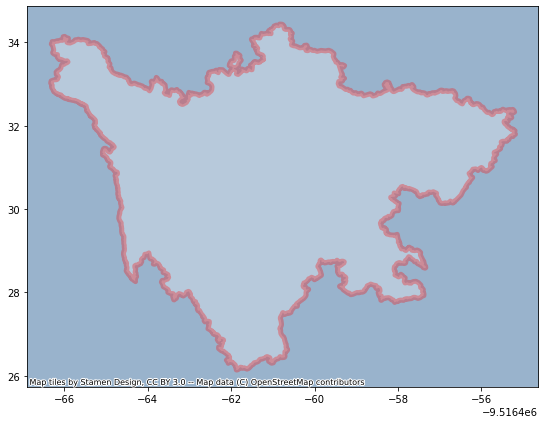

In [8]:
grsm_df = pd.DataFrame([[-9999,-9999,0,-9999,-9999,grsm_epsg4326.geometry.item()]], columns=["agbd", "agbd_se", "l4_quality_flag","lat_lowestmode", "lon_lowestmode", "geometry"])
gdf = pd.concat([gdf, grsm_df])
gdf.crs="EPSG:4326"
gdf_epsg3857 = gdf.to_crs(epsg=3857)
ax4=gdf_epsg3857[-1:].plot(color='white', edgecolor='red', alpha=0.3, linewidth=5, figsize=(22, 7))
gdf_epsg3857[gdf_epsg3857['agbd'] != -9999][:-1].plot(ax=ax4, column='agbd', alpha=0.3, linewidth=0, legend=True)
ctx.add_basemap(ax4)

D:\Miniconda3\lib\site-packages\geopandas\plotting.py:678: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
D:\Miniconda3\lib\site-packages\contextily\tile.py:632: UserWarning: The inferred zoom level of 24 is not valid for the current tile provider (valid zooms: 0 - 18).
  warnings.warn(msg)


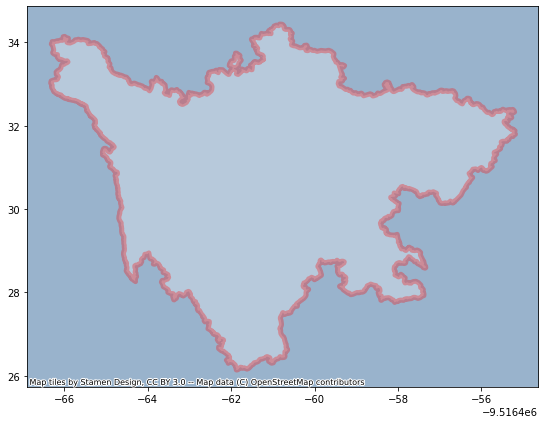

In [9]:
ax4=gdf_epsg3857[-1:].plot(color='white', edgecolor='red', alpha=0.3, linewidth=5, figsize=(22, 7))
gdf_epsg3857[gdf_epsg3857['agbd_se'] != -9999][:-1].plot(ax=ax4, column='agbd_se', alpha=0.3, linewidth=0, legend=True)
ctx.add_basemap(ax4)